# Disease dagnosis with machine learning

In [3]:
! pip install xgboost --quiet
! pip install catboost --quiet
! pip install shap --quiet
! pip install lightgbm --quiet
! pip install optuna --quiet

In [4]:
# importing the needed library
import shap
import math
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression

import optuna
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from joblib import dump
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [7]:
train_data = pd.read_csv('/content/data/Training.csv')
test_data = pd.read_csv('/content/data/Testing.csv')

In [ ]:
train_data.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN


In [ ]:
test_data.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Allergy
2,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,GERD
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chronic cholestasis
4,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Drug Reaction


In [ ]:
train_data.columns

Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'ulcers_on_tongue',
       ...
       'scurring', 'skin_peeling', 'silver_like_dusting',
       'small_dents_in_nails', 'inflammatory_nails', 'blister',
       'red_sore_around_nose', 'yellow_crust_ooze', 'prognosis',
       'Unnamed: 133'],
      dtype='object', length=134)

In [ ]:
train_data.isnull().values.any()

True

In [ ]:
train_data['prognosis'].value_counts()

Fungal infection                           120
Hepatitis C                                120
Hepatitis E                                120
Alcoholic hepatitis                        120
Tuberculosis                               120
Common Cold                                120
Pneumonia                                  120
Dimorphic hemmorhoids(piles)               120
Heart attack                               120
Varicose veins                             120
Hypothyroidism                             120
Hyperthyroidism                            120
Hypoglycemia                               120
Osteoarthristis                            120
Arthritis                                  120
(vertigo) Paroymsal  Positional Vertigo    120
Acne                                       120
Urinary tract infection                    120
Psoriasis                                  120
Hepatitis D                                120
Hepatitis B                                120
Allergy      

In [ ]:
train_data.describe()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,Unnamed: 133
count,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,...,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,4920.000000,0.0
mean,0.137805,0.159756,0.021951,0.045122,0.021951,0.162195,0.139024,0.045122,0.045122,0.021951,...,0.021951,0.021951,0.023171,0.023171,0.023171,0.023171,0.023171,0.023171,0.023171,NaN
std,0.344730,0.366417,0.146539,0.207593,0.146539,0.368667,0.346007,0.207593,0.207593,0.146539,...,0.146539,0.146539,0.150461,0.150461,0.150461,0.150461,0.150461,0.150461,0.150461,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN


In [ ]:
train_data.shape

(4920, 134)

### Feature selection based on weight and correlation

<Axes: >

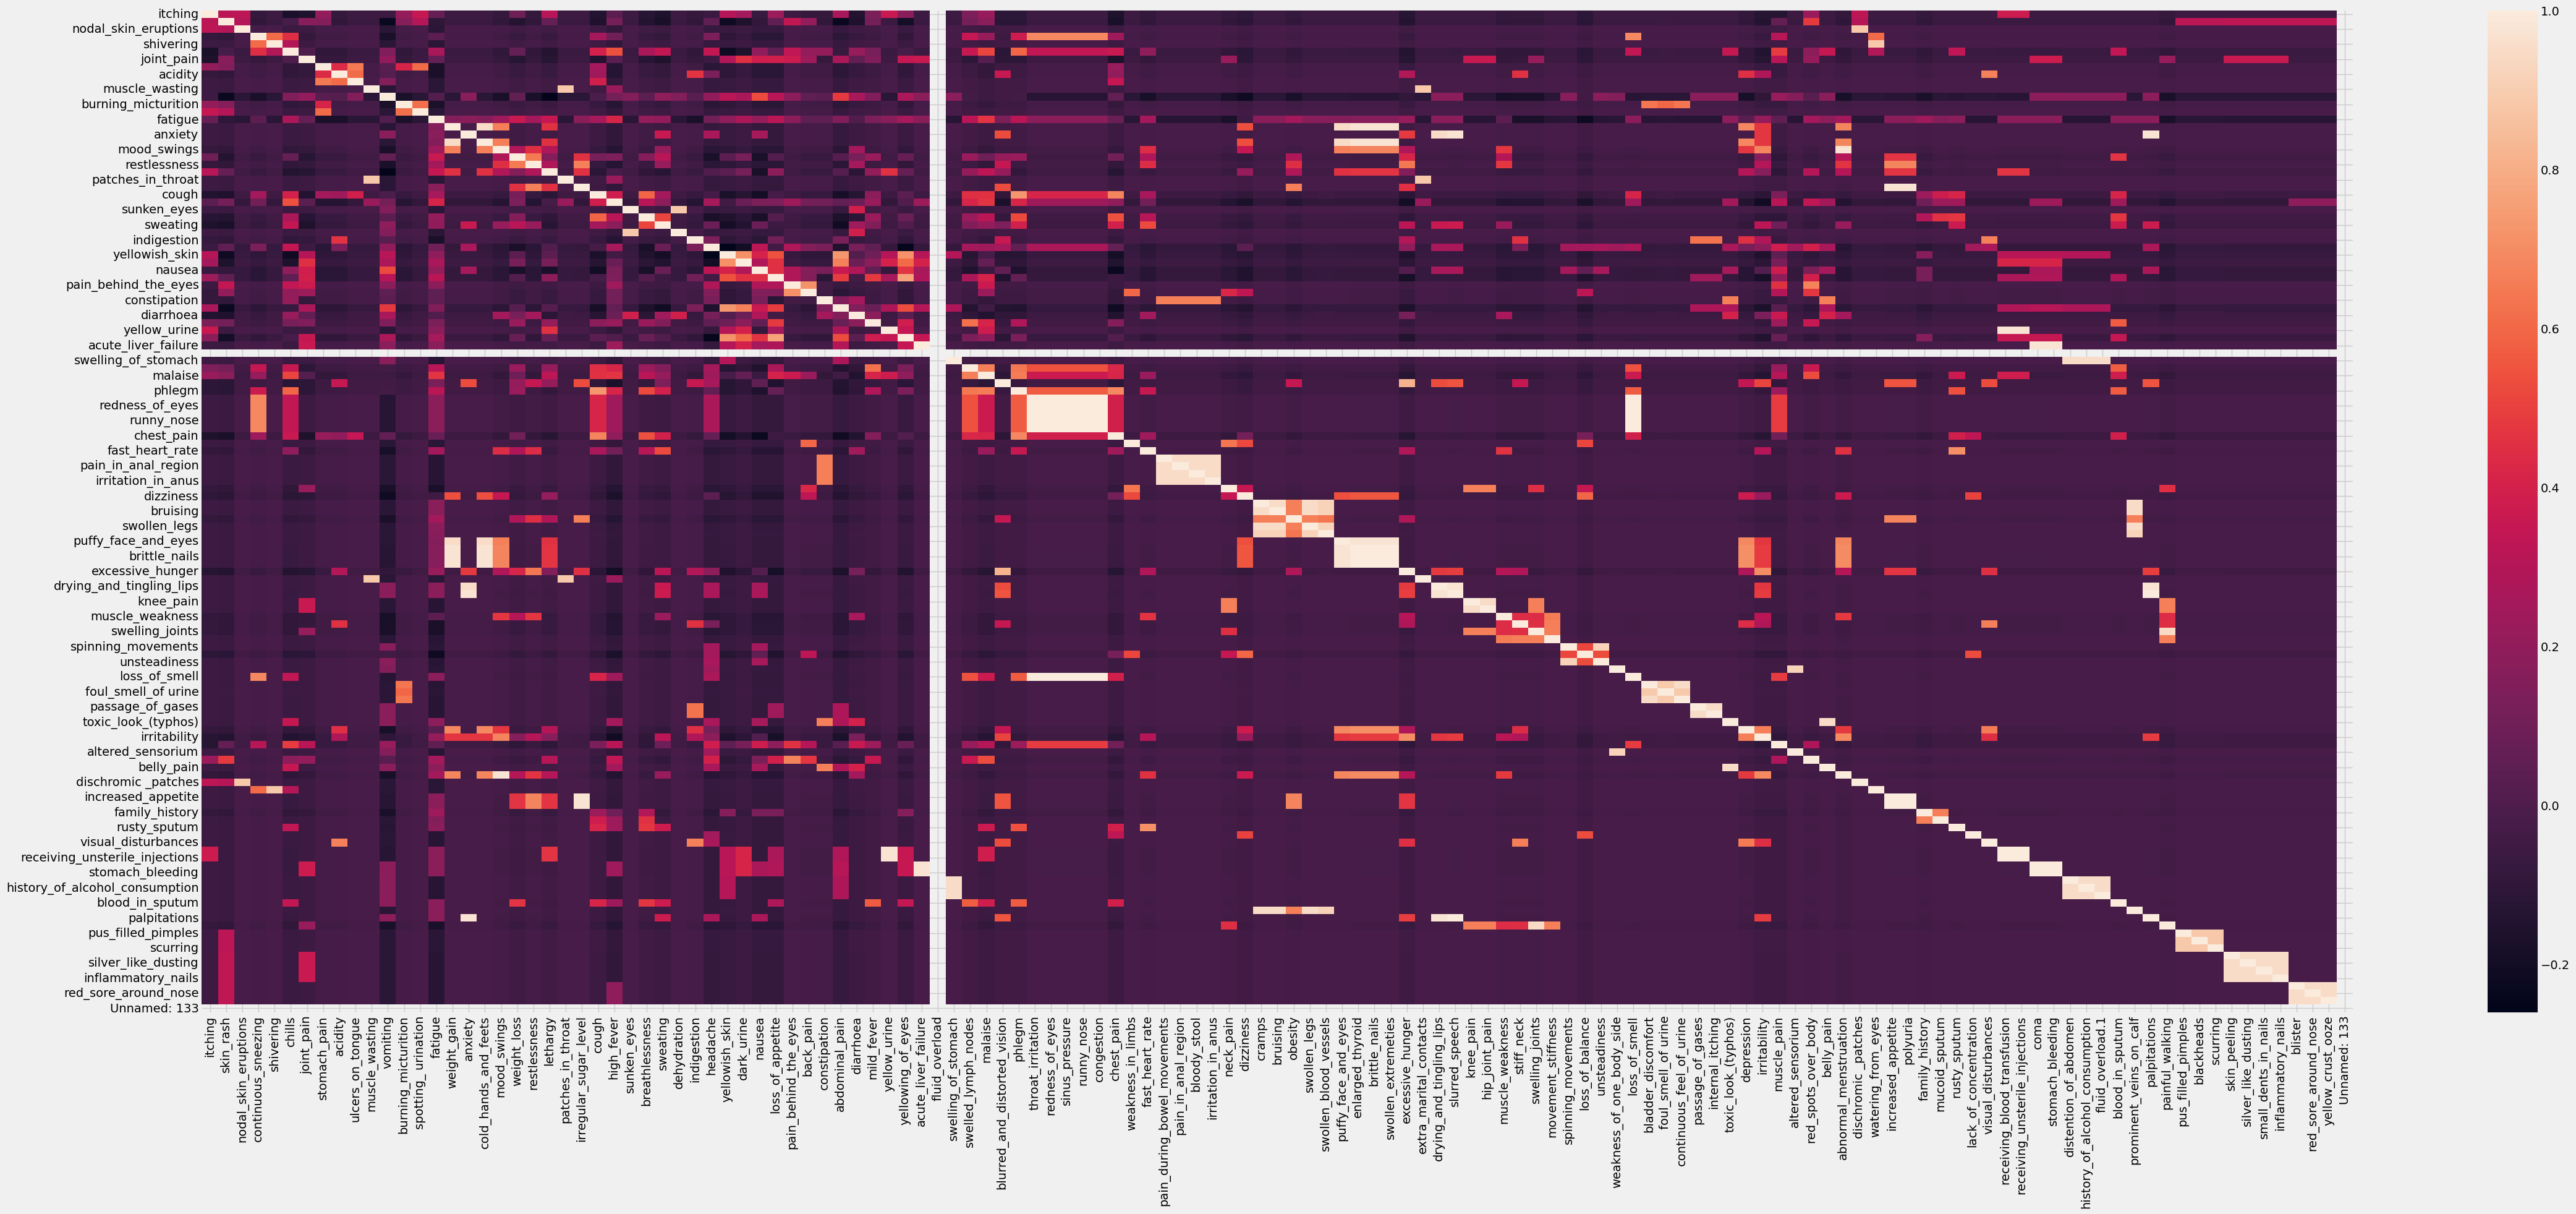

In [ ]:
plt.figure(figsize = (50, 20))
sns.heatmap(train_data.corr())

In [8]:
# Dropping the correlated values with 80% and above correlation

corr_matrix = train_data.corr()

# Set the correlation threshold for removal
corr_threshold = 0.8

# Find and remove correlated features
col_to_remove = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            col_name = corr_matrix.columns[i]
            col_to_remove.add(col_name)

tdata = train_data.drop(columns=col_to_remove)

In [ ]:
tdata.shape

(4920, 83)

In [9]:
le = LabelEncoder()
x = tdata.drop(['prognosis'], axis = 1)# independent features
y = le.fit_transform(tdata['prognosis'])# dependent features

In [10]:
# Splitting the dataset into train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 3)

In [11]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [12]:
#checking if xgboost is overfitted or underfitted with with cross validation
scores = cross_val_score(XGBClassifier(), x_train, y_train,
                              cv=7,
                              scoring="accuracy")

print("MAE score:\n", scores.mean())

MAE score:
 0.9992374173868835


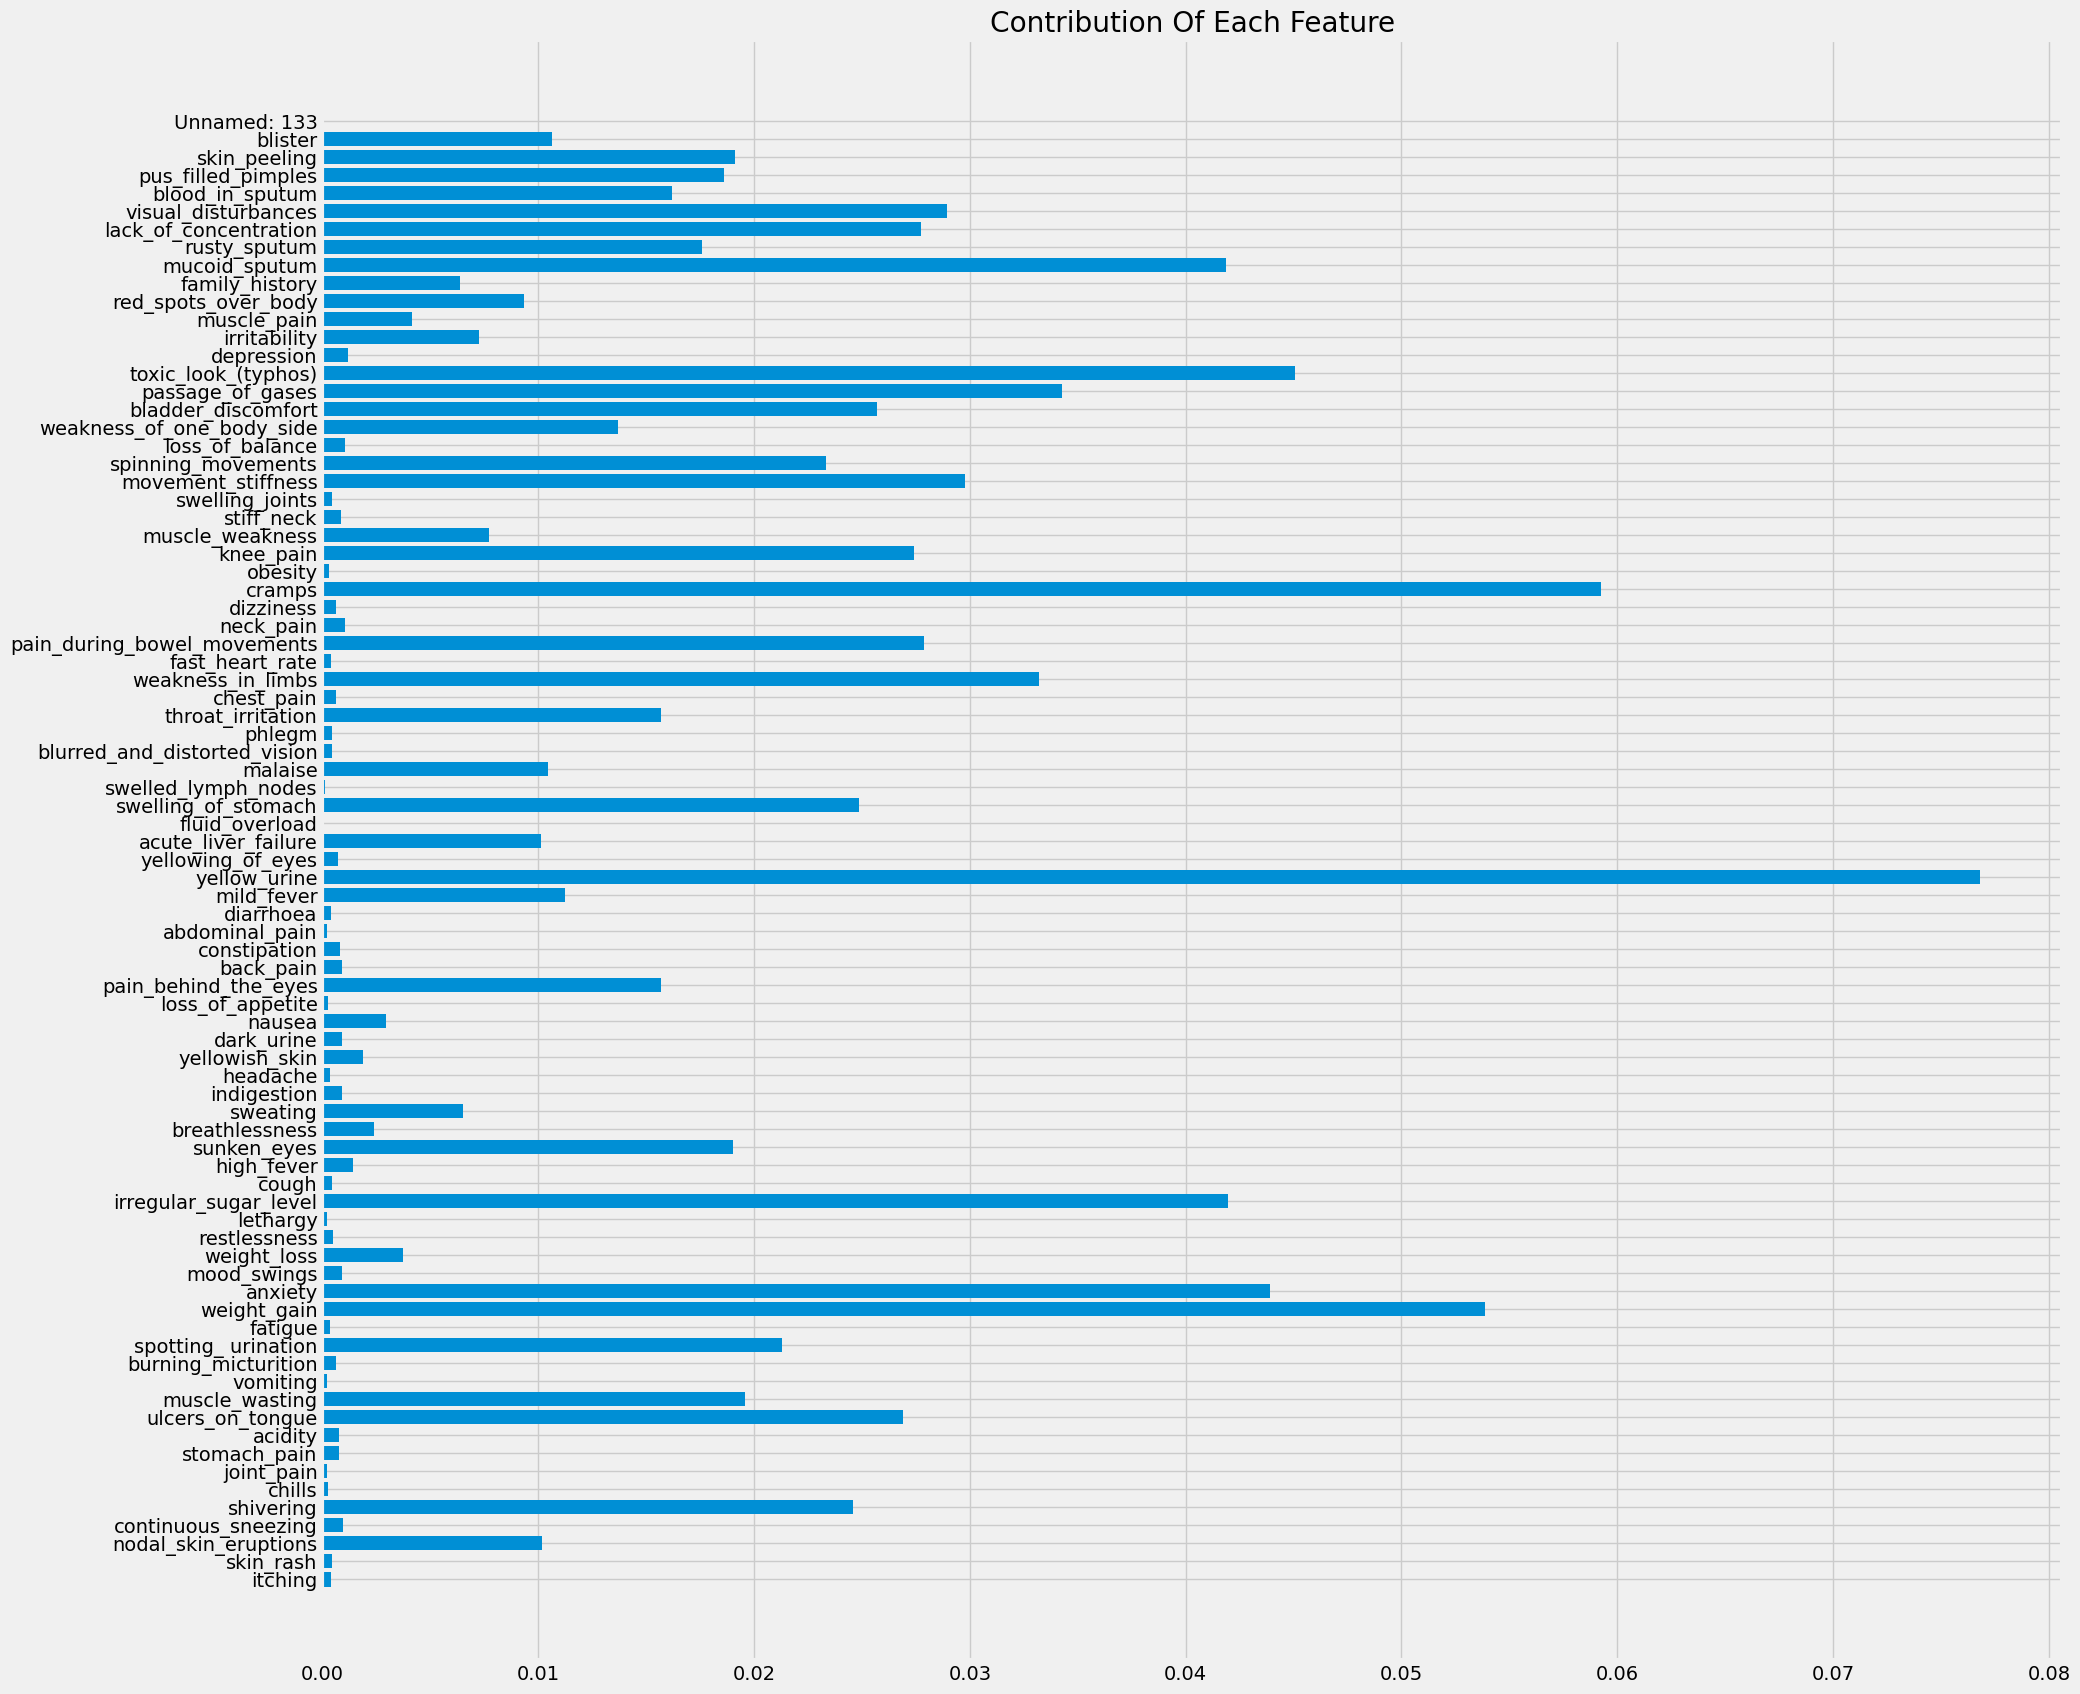

In [ ]:
plt.figure(figsize=(20, 20))
plt.barh(x.columns, xgb.feature_importances_)
plt.title("Contribution Of Each Feature")
plt.show()

In [ ]:
fi_df = pd.DataFrame({'Feature': x.columns, 'Importance': xgb.feature_importances_})

fi_df = fi_df.sort_values(by='Importance', ascending=False)

fi_df.head(45)

,Feature,Importance
0,yellow_urine,0.112249
4,anxiety,0.070175
6,mucoid_sputum,0.066953
3,toxic_look_(typhos),0.037036
9,movement_stiffness,0.028725
27,throat_irritation,0.027476
26,pain_behind_the_eyes,0.027415
7,passage_of_gases,0.026713
12,lack_of_concentration,0.026320
1,cramps,0.025857


In [ ]:
# Selecting only the top 45 features
fi_df['Feature'][: 45].unique()

array(['yellow_urine', 'cramps', 'weight_gain', 'toxic_look_(typhos)',
       'anxiety', 'irregular_sugar_level', 'mucoid_sputum',
       'passage_of_gases', 'weakness_in_limbs', 'movement_stiffness',
       'visual_disturbances', 'pain_during_bowel_movements',
       'lack_of_concentration', 'knee_pain', 'ulcers_on_tongue',
       'bladder_discomfort', 'swelling_of_stomach', 'shivering',
       'spinning_movements', 'spotting_ urination', 'muscle_wasting',
       'skin_peeling', 'sunken_eyes', 'pus_filled_pimples',
       'rusty_sputum', 'blood_in_sputum', 'pain_behind_the_eyes',
       'throat_irritation', 'weakness_of_one_body_side', 'mild_fever',
       'blister', 'malaise', 'nodal_skin_eruptions',
       'acute_liver_failure', 'red_spots_over_body', 'muscle_weakness',
       'irritability', 'sweating', 'family_history', 'muscle_pain',
       'weight_loss', 'nausea', 'breathlessness', 'yellowish_skin',
       'high_fever'], dtype=object)

In [13]:
new_df = train_data[['yellow_urine', 'cramps', 'weight_gain', 'toxic_look_(typhos)',
       'anxiety', 'irregular_sugar_level', 'mucoid_sputum',
       'passage_of_gases', 'weakness_in_limbs', 'movement_stiffness',
       'visual_disturbances', 'pain_during_bowel_movements',
       'lack_of_concentration', 'knee_pain', 'ulcers_on_tongue',
       'bladder_discomfort', 'swelling_of_stomach', 'shivering',
       'spinning_movements', 'spotting_ urination', 'muscle_wasting',
       'skin_peeling', 'sunken_eyes', 'pus_filled_pimples',
       'rusty_sputum', 'blood_in_sputum', 'pain_behind_the_eyes',
       'throat_irritation', 'weakness_of_one_body_side', 'mild_fever',
       'blister', 'malaise', 'nodal_skin_eruptions',
       'acute_liver_failure', 'red_spots_over_body', 'muscle_weakness',
       'irritability', 'sweating', 'family_history', 'muscle_pain',
       'weight_loss', 'nausea', 'breathlessness', 'yellowish_skin',
       'high_fever', 'prognosis']]

In [ ]:
new_df.head()

,yellow_urine,cramps,weight_gain,toxic_look_(typhos),anxiety,irregular_sugar_level,mucoid_sputum,passage_of_gases,weakness_in_limbs,movement_stiffness,...,irritability,sweating,family_history,muscle_pain,weight_loss,nausea,breathlessness,yellowish_skin,high_fever,prognosis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection


- After dropping correlated columns and dropping columns with less feature importance, the remaining 46 columns will be used for further analysis and modelling.

## Exploratory Data Analysis
### Univariate analysis

In [23]:
#writing a function to plot two features
def countplot(first, second):
  fig, ax = plt.subplots(1, 2, figsize = [13,5])

  sns.countplot(x = new_df[first], ax = ax[0]).set_title(f"{first} distribution")
  sns.countplot(x = new_df[second], ax = ax[1]).set_title(f"{second} distribution")

  fig.show()

In [15]:
new_df.columns

Index(['yellow_urine', 'cramps', 'weight_gain', 'toxic_look_(typhos)',
       'anxiety', 'irregular_sugar_level', 'mucoid_sputum', 'passage_of_gases',
       'weakness_in_limbs', 'movement_stiffness', 'visual_disturbances',
       'pain_during_bowel_movements', 'lack_of_concentration', 'knee_pain',
       'ulcers_on_tongue', 'bladder_discomfort', 'swelling_of_stomach',
       'shivering', 'spinning_movements', 'spotting_ urination',
       'muscle_wasting', 'skin_peeling', 'sunken_eyes', 'pus_filled_pimples',
       'rusty_sputum', 'blood_in_sputum', 'pain_behind_the_eyes',
       'throat_irritation', 'weakness_of_one_body_side', 'mild_fever',
       'blister', 'malaise', 'nodal_skin_eruptions', 'acute_liver_failure',
       'red_spots_over_body', 'muscle_weakness', 'irritability', 'sweating',
       'family_history', 'muscle_pain', 'weight_loss', 'nausea',
       'breathlessness', 'yellowish_skin', 'high_fever', 'prognosis'],
      dtype='object')

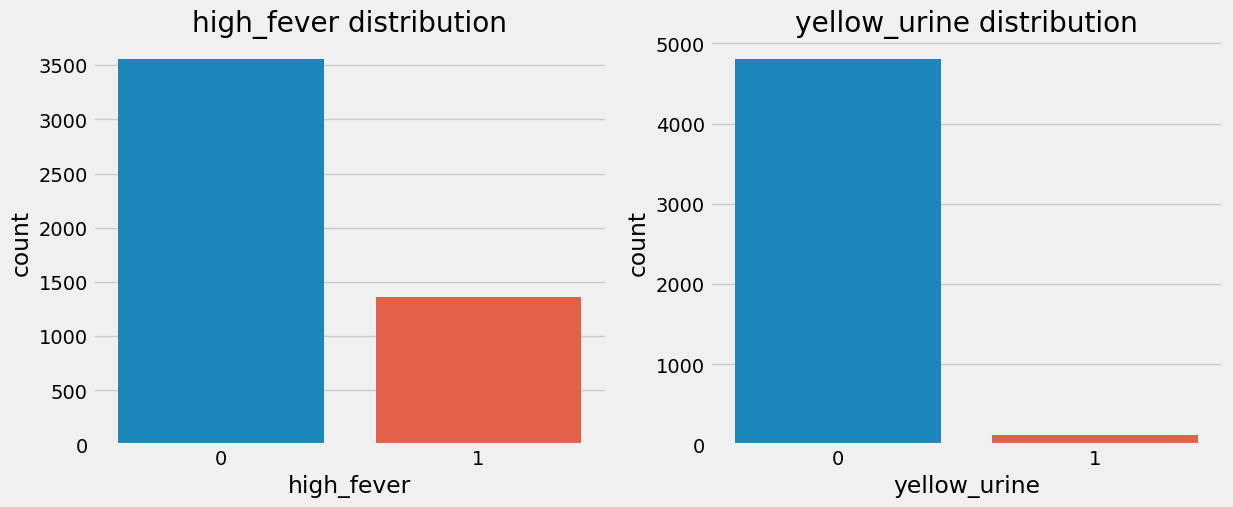

In [24]:
countplot('high_fever', 'yellow_urine')

- From the observation, most of the poeple do not have high fever and yellow urine.

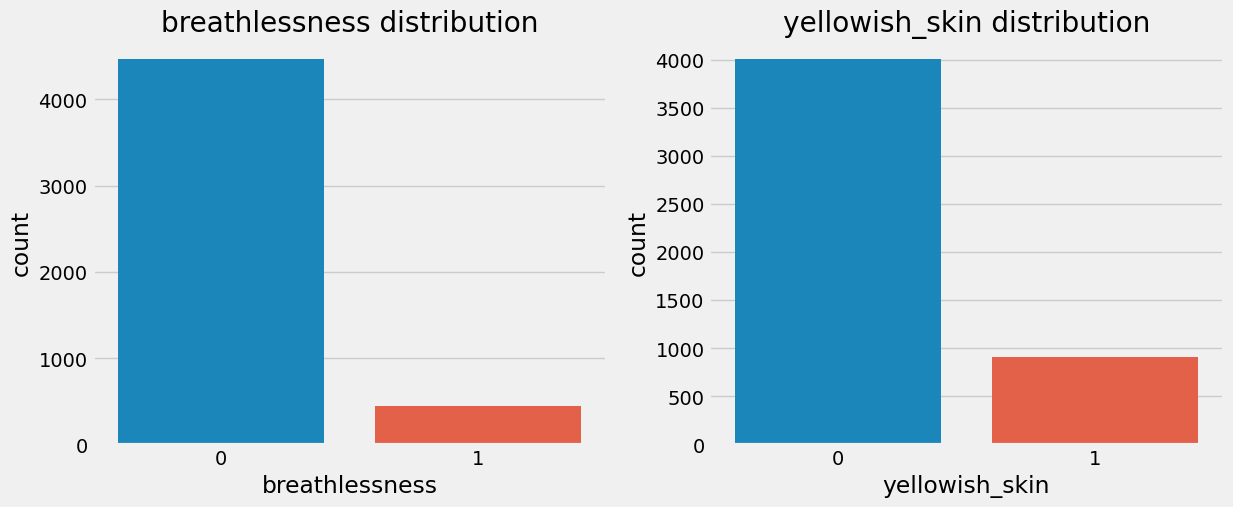

In [25]:
countplot('breathlessness', 'yellowish_skin')

- Most of the people do not have breathlessness as well as yellow skin

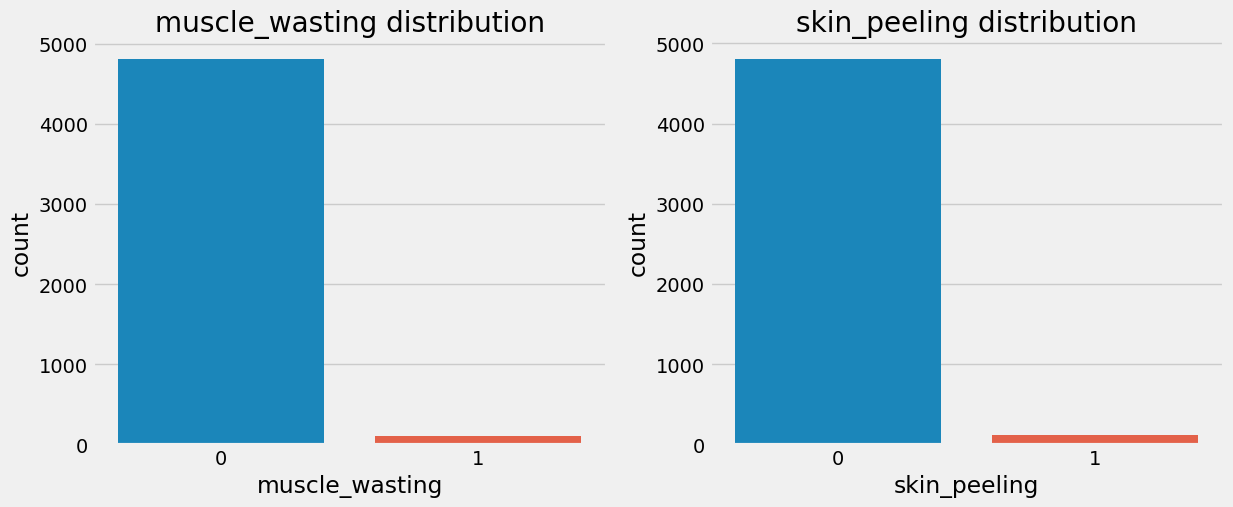

In [26]:
countplot('muscle_wasting', 'skin_peeling')

- Most of the people co not have muscle wasting and skin peeling and a correlation can be observed from the two features. One of the features will be dropped

## Bi variate Analysis

In [27]:
def countplott(first, second, third):
  fig, ax = plt.subplots(1, 2, figsize = [13,5])

  sns.countplot(x = new_df[first], hue = new_df[second], ax = ax[0]).set_title(f"Relationship between {first} and {second}")
  sns.countplot(x = new_df[first], hue = new_df[third], ax = ax[1]).set_title(f"Relationship between {first} and {third}")

  fig.show()

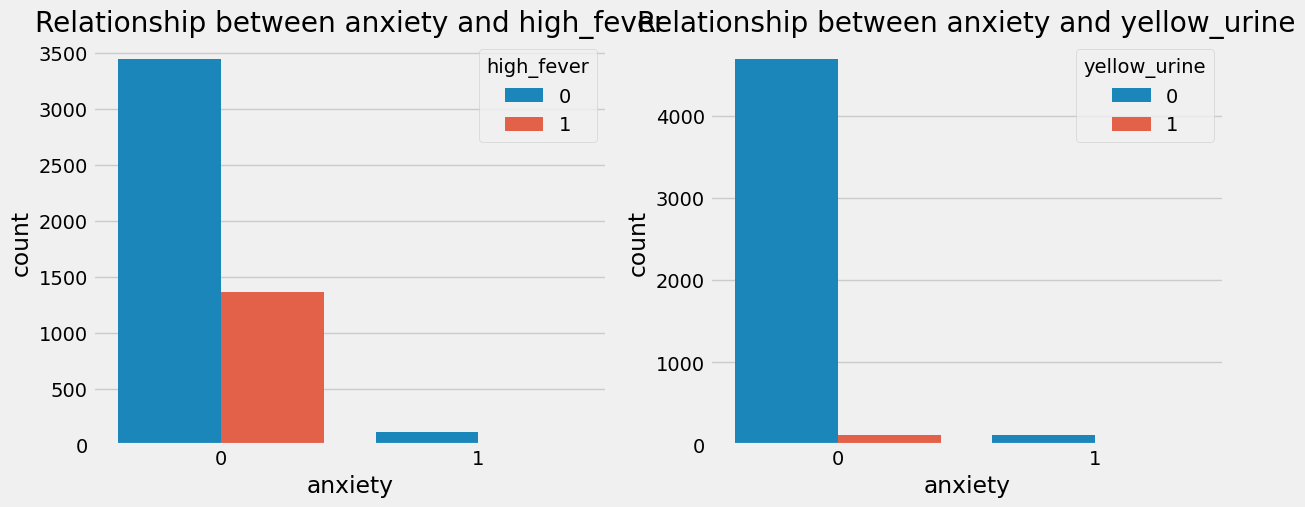

In [29]:
countplott('anxiety', 'high_fever', 'yellow_urine')

- Most of the peoplw that do not have anxiety do not have high fever as well
- Most of the peoplw that do not have anxiety do not have yellow urine as well and none of the peole that have anxiety have yeloo blood

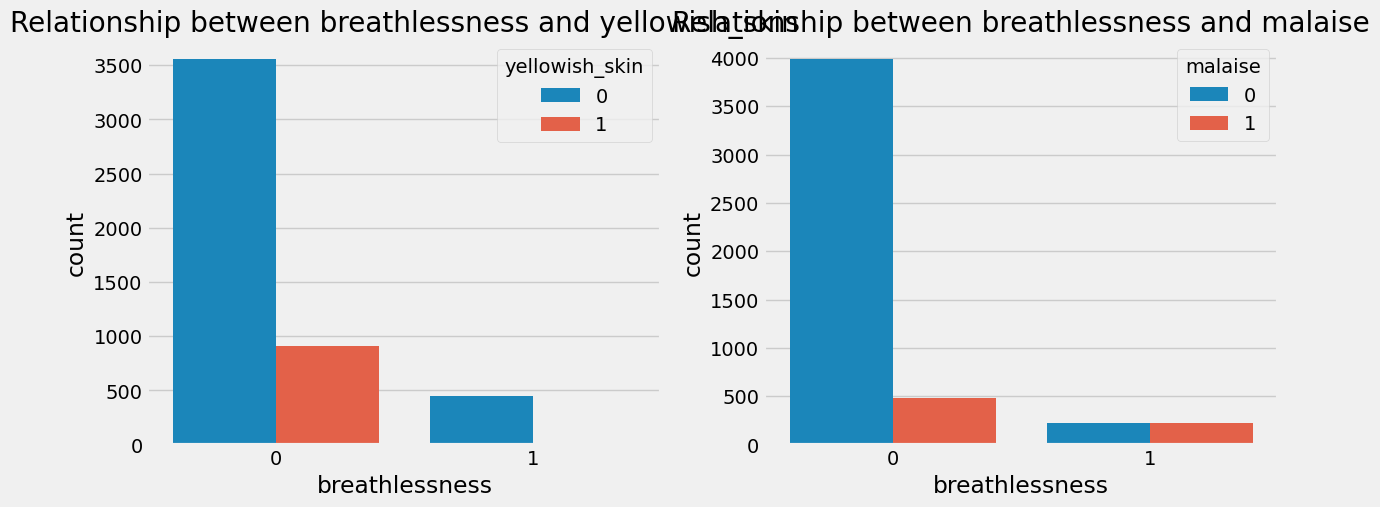

In [31]:
countplott('breathlessness', 'yellowish_skin', 'malaise')